In [1]:
# install.packages("blackmarbler")
# install.packages("terra")

In [1]:
library(sf)
library(dplyr)
library(lubridate)
library(purrr)
library(arrow)
library(blackmarbler)
library(tibble)

Warning message:
"package 'sf' was built under R version 4.5.2"
Linking to GEOS 3.13.1, GDAL 3.11.4, PROJ 9.7.0; sf_use_s2() is TRUE


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'arrow'


The following object is masked from 'package:lubridate':

    duration


The following object is masked from 'package:utils':

    timestamp


Warning message:
"package 'blackmarbler' was built under R version 4.5.2"


In [3]:
bearer <- Sys.getenv("BLACKMARBLE_TOKEN")  # your Earthdata bearer token
stopifnot(nchar(bearer) > 20)

In [4]:
# Import the polygon object
us_places <- st_read("../data/us_places.geojson")|>
    st_transform(crs = 4326)

Reading layer `us_places' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\ntl_crime\data\us_places.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32041 features and 12 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -176.6967 ymin: 19.01848 xmax: 174.1553 ymax: 71.33971
Geodetic CRS:  WGS 84


In [5]:
# Show features of us places
print(us_places)

Simple feature collection with 32041 features and 12 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -176.6967 ymin: 19.01848 xmax: 174.1553 ymax: 71.33971
Geodetic CRS:  WGS 84
First 10 features:
   STATEFP PLACEFP  PLACENS          GEOIDFQ   GEOID          NAME
1       35   83340 02413599 1600000US3583340 3583340   Wagon Mound
2       35   33290 02413559 1600000US3533290 3533290          Hope
3       35   12150 02409985 1600000US3512150 3512150      Carlsbad
4       35   62620 02413582 1600000US3562620 3562620       Reserve
5       35   70270 02413590 1600000US3570270 3570270   Santa Clara
6       35   68150 02413587 1600000US3568150 3568150       San Jon
7       35   06830 02584055 1600000US3506830 3506830        Berino
8       35   51840 02584163 1600000US3551840 3551840       Newkirk
9       35   48425 02584154 1600000US3548425 3548425 Middle Frisco
10      35   26010 02584100 1600000US3526010 3526010    Fence Lake
              NAMELSAD STUSPS STATE_NAME

In [6]:
# Define a test using one polygon for one time period
test_polygon <- us_places |>
    filter(NAME == "Wagon Mound") |>
    slice(1)

# VNP46A3 is a monthly product; June 2020 corresponds to one file
test_month <- "2020-08"

ntl <- blackmarbler::bm_raster(
  roi_sf     = test_polygon,
  product_id = "VNP46A3",
  date       = test_month,
  bearer     = bearer,
  aggregation_fun  = "mean",
  quiet      = FALSE
)

ntl

Warning message:
"Failed to open 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5200/VNP46A3/2020/213.csv': The requested URL returned error: 404"
Processing 1 nighttime light tiles

Processing: VNP46A3.A2020214.h07v05.002.2025133222304.h5



class       : SpatRaster 
size        : 5, 8, 1  (nrow, ncol, nlyr)
resolution  : 0.004166667, 0.004166667  (x, y)
extent      : -104.725, -104.6917, 35.99583, 36.01667  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source(s)   : memory
varname     : NearNadir_Composite_Snow_Free 
name        : t2020_08 
min value   : 0.000000 
max value   : 7.787655 

In [7]:
months <- seq.Date(from = as.Date("2012-01-01"),
                   to   = as.Date("2024-12-01"),
                   by   = "month")

month_str <- format(months, "%Y-%m")


In [8]:
safe_extract_month <- function(m_str, places_sf, bearer) {
  if (!("GEOID" %in% names(places_sf))) {
    stop("places_sf must contain a column named 'GEOID'.")
  }

  id_df <- places_sf |>
    sf::st_drop_geometry() |>
    dplyr::select(GEOID) |>
    dplyr::distinct()

  tryCatch({
    res <- blackmarbler::bm_extract(
      roi_sf                = places_sf,
      product_id            = "VNP46A3",
      date                  = m_str,         # "YYYY-MM"
      bearer                = bearer,
      aggregation_fun       = "mean",
      add_n_pixels          = TRUE,
      check_all_tiles_exist = FALSE,
      quiet                 = TRUE
    )

    # Ensure GEOID exists in output
    if (!("GEOID" %in% names(res))) {
      if (nrow(res) == nrow(places_sf)) {
        res <- dplyr::bind_cols(dplyr::select(sf::st_drop_geometry(places_sf), GEOID), res)
      } else {
        # fallback
        res <- dplyr::bind_cols(id_df, res)
      }
    }

    res |>
      dplyr::mutate(
        month  = as.Date(paste0(m_str, "-01")),
        status = "ok"
      )
  }, error = function(e) {
    id_df |>
      dplyr::mutate(
        month  = as.Date(paste0(m_str, "-01")),
        status = "missing_or_failed",
        error  = substr(conditionMessage(e), 1, 200)
      )
  })
}


In [9]:
# Ensure EPSG:4326 (required)
us_places <- st_transform(us_places, 4326)

# Ensure STATEFP is character with leading zeros
us_places <- us_places %>%
  mutate(STATEFP = as.character(STATEFP)) %>%
  mutate(STATEFP = ifelse(nchar(STATEFP) == 1, paste0("0", STATEFP), STATEFP))

places_ak    <- us_places %>% filter(STATEFP == "02")
places_hi    <- us_places %>% filter(STATEFP == "15")
places_conus <- us_places %>% filter(!STATEFP %in% c("02", "15"))

cat("CONUS:", nrow(places_conus), " AK:", nrow(places_ak), " HI:", nrow(places_hi), "\n")


CONUS: 31523  AK: 355  HI: 163 


In [10]:
bearer <- Sys.getenv("BLACKMARBLE_TOKEN")
stopifnot(nchar(bearer) > 20)

out_dir <- "../data/ntl_vnp46a3_places/"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

run_state <- function(places_state, state_label) {
  message("Running: ", state_label, " (n=", nrow(places_state), ")")

  res_list <- purrr::map(month_str, safe_extract_month, places_sf = places_state, bearer = bearer)
  res <- dplyr::bind_rows(res_list)

  arrow::write_parquet(res, file.path(out_dir, paste0("ntl_vnp46a3_", state_label, ".parquet")))
  invisible(res)
}

# CONUS: loop through states
conus_states <- sort(unique(places_conus$STATEFP))
for (st in conus_states) {
  run_state(places_conus %>% filter(STATEFP == st), paste0("STATEFP_", st))
}

Running: STATEFP_01 (n=594)

Warning message:
"Failed to open 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5200/VNP46A3/2012/060.csv': The requested URL returned error: 404"
Warning message:
"Failed to open 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5200/VNP46A3/2012/091.csv': The requested URL returned error: 404"
Warning message:
"Failed to open 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5200/VNP46A3/2012/121.csv': The requested URL returned error: 404"
Warning message:
"Failed to open 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5200/VNP46A3/2012/152.csv': The requested URL returned error: 404"
Warning message:
"Failed to open 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5200/VNP46A3/2012/182.csv': The requested URL returned error: 404"
Warning message:
"Failed to open 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/5200/VNP46A3/2012/213.csv': The requested URL returned error: 404"
Warning message:
"Failed to open 'h

In [11]:
# Alaska and Hawaii separately (explicit requirement)
run_state(places_ak, "STATEFP_02_AK")
run_state(places_hi, "STATEFP_15_HI")


Running: STATEFP_02_AK (n=355)

Warning message in bm_raster_i(roi_sf = roi_sf, product_id = product_id, date = date_i, :
"No satellite imagery exists for 2012-01-01; skipping"
Warning message in bm_raster_i(roi_sf = roi_sf, product_id = product_id, date = date_i, :
"No satellite imagery exists for 2012-02-01; skipping"
Warning message in bm_raster_i(roi_sf = roi_sf, product_id = product_id, date = date_i, :
"No satellite imagery exists for 2012-03-01; skipping"
Warning message in bm_raster_i(roi_sf = roi_sf, product_id = product_id, date = date_i, :
"No satellite imagery exists for 2012-04-01; skipping"
Warning message in bm_raster_i(roi_sf = roi_sf, product_id = product_id, date = date_i, :
"No satellite imagery exists for 2012-05-01; skipping"
Warning message in bm_raster_i(roi_sf = roi_sf, product_id = product_id, date = date_i, :
"No satellite imagery exists for 2012-06-01; skipping"
Warning message in bm_raster_i(roi_sf = roi_sf, product_id = product_id, date = date_i, :
"No sate

In [12]:
ds <- arrow::open_dataset(out_dir)
ntl_panel <- ds %>% collect()

In [13]:
str(ntl_panel)

# Save the combined data
arrow::write_parquet(ntl_panel, file.path("../data/ntl_vnp46a3_all_places_2012_2024.parquet"))

tibble [4,998,396 x 20] (S3: tbl_df/tbl/data.frame)
 $ STATEFP           : chr [1:4998396] "01" "01" "01" "01" ...
 $ PLACEFP           : chr [1:4998396] "32704" "45472" "53784" "78204" ...
 $ PLACENS           : chr [1:4998396] "02403782" "02406131" "02406982" "02405634" ...
 $ GEOIDFQ           : chr [1:4998396] "1600000US0132704" "1600000US0145472" "1600000US0153784" "1600000US0178204" ...
 $ GEOID             : chr [1:4998396] "0132704" "0145472" "0153784" "0178204" ...
 $ NAME              : chr [1:4998396] "Haleyville" "McIntosh" "Newbern" "Valley" ...
 $ NAMELSAD          : chr [1:4998396] "Haleyville city" "McIntosh town" "Newbern town" "Valley city" ...
 $ STUSPS            : chr [1:4998396] "AL" "AL" "AL" "AL" ...
 $ STATE_NAME        : chr [1:4998396] "Alabama" "Alabama" "Alabama" "Alabama" ...
 $ LSAD              : chr [1:4998396] "25" "43" "43" "25" ...
 $ ALAND             : num [1:4998396] 21713018 2579767 3010370 33384157 16064130 ...
 $ AWATER            : num [1:4998

In [2]:
# Read in the combined data
ntl_panel <- arrow::read_parquet(file.path("../data/ntl_vnp46a3_all_places_2012_2024.parquet"))

# Read the geojson again to get geometries
us_places <- st_read("../data/us_places.geojson") |>
  st_transform(crs = 4326)|>
  select(GEOID, geometry)

# Join geometries to the panel data
# Do NOT drop geometry from us_places so it can be converted back to SF
ntl_panel <- ntl_panel |>
  left_join(us_places, by = "GEOID") |>
  st_as_sf()

# Convert all column names to lower
names(ntl_panel) <- tolower(names(ntl_panel))

# View the updated data
str(ntl_panel)

Reading layer `us_places' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\ntl_crime\data\us_places.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32041 features and 12 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -176.6967 ymin: 19.01848 xmax: 174.1553 ymax: 71.33971
Geodetic CRS:  WGS 84
sf [4,998,396 x 21] (S3: sf/tbl_df/tbl/data.frame)
 $ statefp           : chr [1:4998396] "01" "01" "01" "01" ...
 $ placefp           : chr [1:4998396] "32704" "45472" "53784" "78204" ...
 $ placens           : chr [1:4998396] "02403782" "02406131" "02406982" "02405634" ...
 $ geoidfq           : chr [1:4998396] "1600000US0132704" "1600000US0145472" "1600000US0153784" "1600000US0178204" ...
 $ geoid             : chr [1:4998396] "0132704" "0145472" "0153784" "0178204" ...
 $ name              : chr [1:4998396] "Haleyville" "McIntosh" "Newbern" "Valley" ...
 $ namelsad          : chr [1:4998396] "Haleyville city" "McIntosh town" "Newbern town" "Valley

In [3]:
# Investigate any failed/missing extractions
missing_data <- ntl_panel |>
  filter(status != "ok")
print(missing_data)

Simple feature collection with 4910484 features and 20 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -176.6967 ymin: 19.01848 xmax: 174.1553 ymax: 71.33971
Geodetic CRS:  WGS 84
# A tibble: 4,910,484 x 21
   statefp placefp placens geoidfq geoid  name  namelsad stusps state_name lsad 
 * <chr>   <chr>   <chr>   <chr>   <chr>  <chr> <chr>    <chr>  <chr>      <chr>
 1 NA      NA      NA      NA      01327~ NA    NA       NA     NA         NA   
 2 NA      NA      NA      NA      01454~ NA    NA       NA     NA         NA   
 3 NA      NA      NA      NA      01537~ NA    NA       NA     NA         NA   
 4 NA      NA      NA      NA      01782~ NA    NA       NA     NA         NA   
 5 NA      NA      NA      NA      01028~ NA    NA       NA     NA         NA   
 6 NA      NA      NA      NA      01620~ NA    NA       NA     NA         NA   
 7 NA      NA      NA      NA      01779~ NA    NA       NA     NA         NA   
 8 NA      NA      NA      NA      012

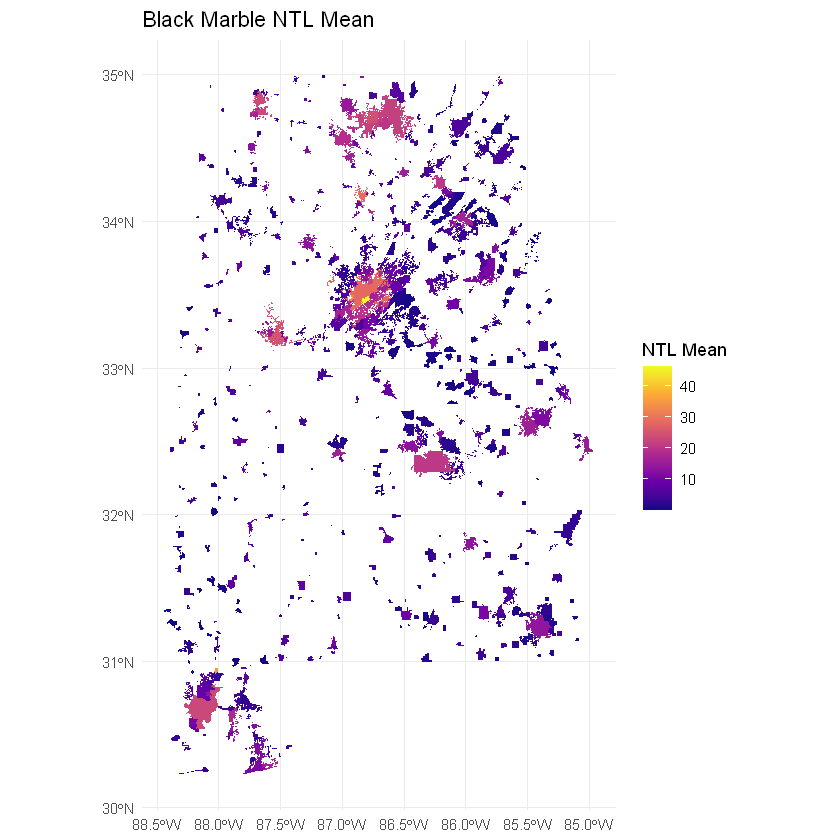

: 

In [ ]:
# Visualize the NTL mean for at 2012-01 
library(ggplot2)

ggplot(data = ntl_panel %>% filter(date == "2024-01")) +
  geom_sf(aes(fill = ntl_mean), color = NA) +
  scale_fill_viridis_c(option = "plasma", na.value = "lightgrey") +
  theme_minimal() +
  labs(title = "Black Marble NTL Mean",
       fill  = "NTL Mean")

In [ ]:
# Save the updated data with geometries
arrow::write_parquet(ntl_panel, file.path("../data/ntl_vnp46a3_all_places_2012_2024_with_geometry.parquet"))